# 3. Evaluate Model

# 3.0 -- Import Relevant Libraries

In [1]:
import keras

/home/dustin/anaconda3/envs/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/dustin/anaconda3/envs/tensorflow/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
from sklearn.metrics import confusion_matrix

In [3]:
import pandas as pd
import numpy as np
import pickle
import os

In [4]:
#pickle_path = 'Pickled/Small_Train/'

pickle_path = 'Pickled/Train_Data/'

#pickle_path = 'Pickled/Test_Data/'

# 3.1 -- Define Data Generator

### Similar to before, get the log mean of all of the training data and feed into the Data_Gen() function.

In [5]:
X_files = sorted(os.listdir(pickle_path + "Spectra"))
num_files = len(X_files)
count=0

mean_list=[]

for X_file in X_files:
    
    # X Data
    file = open(pickle_path + "Spectra/" + X_file, "rb")
    X=pickle.load(file)
    file.close()
    
    mean_list.append(np.mean(np.log(X)))
    
    count+=1
    percent_complete = round(count/num_files*100,1)
    print(str(percent_complete) + '% Complete', end='\r', flush=True)
    
mean_log_amplitude = np.mean(mean_list)

In [6]:
print("Mean: " + str(round(mean_log_amplitude,3)))
print("2 sigma: " + str(round(2*np.std(mean_list),3)))

Mean: -10.189
2 sigma: 0.062


### Need to switch path to test data!

In [7]:
#pickle_path = 'Pickled/Small_Train/'

#pickle_path = 'Pickled/Train_Data/'

pickle_path = 'Pickled/Test_Data/'

In [8]:
# Returns i-th chunk of X,y data at path.
def Data_Gen(X_path, y_path, mean_log_amplitude):
    
    # X data
    file = open(pickle_path + "Spectra/" + X_path, "rb")
    X=pickle.load(file)
    file.close()
    
    X = np.stack((X,), -1)    
    X = np.log(X) - mean_log_amplitude
    
    file = open(pickle_path + "Targets/" + y_path, "rb")
    y=pickle.load(file)
    file.close()
    
    # y data
    y = keras.utils.np_utils.to_categorical(y)        
    
    return X,y

# 3.2 Load & Test Previously Trained Model

In [9]:
model = keras.models.load_model("Model/Scratch_Aug_1_hrange_pm20_v3.h5")

### The above model was trained all all ~6.8 GB of data WITH augmentation performed 100% of the time.

In [10]:
loss = []
accuracy = []

X_files = sorted(os.listdir(pickle_path + "Spectra"))
y_files = sorted(os.listdir(pickle_path + "Targets"))
iteration = 0

print("Working...")
for X,y in zip(X_files, y_files):
    
    X_test, y_test = Data_Gen(X, y, mean_log_amplitude)            
    results = model.evaluate(X_test, y_test, verbose=0)
    
    
    loss.append(results[0])
    accuracy.append(results[1])
    
    
    iteration+=1
    percent_complete = round(100*iteration/len(y_files), 2)
    print(str(percent_complete) + '% complete', end='\r', flush=True)
    

Working...


### Let's get some stats on the test data...

In [11]:
print("Mean Accuracy: " + str(round(np.mean(accuracy),3)))
print("2 sigma error: " + str(round(2*np.std(accuracy),3)))
print("Mean Loss: "     + str(round(np.mean(loss),3)))
print("2 sigma error: " + str(round(2*np.std(loss),3)))

Mean Accuracy: 0.913
2 sigma error: 0.022
Mean Loss: 0.232
2 sigma error: 0.056


### This model gets an accuracy of $(91 \pm 2)\%$ at $2\sigma$! This is a large improvement from transfer learning. However, knowing where the model fails is still of interest.

# 3.3 Confusion Matrix

In [12]:
y_pred=[]
y_true=[]

iteration = 0

for X,y in zip(X_files, y_files):
    
    X_test, y_test = Data_Gen(X, y, mean_log_amplitude)            
    predicted_class=model.predict(X_test)

    for predicted, true in zip(predicted_class, y_test):
    
        y_pred.append(np.argmax(predicted))
        y_true.append(np.argmax(true))
        
    iteration+=1
    percent_complete = round(100*iteration/len(y_files), 2)
    print(str(percent_complete) + '% complete', end='\r', flush=True)


In [13]:
CM = confusion_matrix(y_pred,y_true)

CM = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]

In [14]:
import seaborn as sn
import matplotlib.pyplot as plt

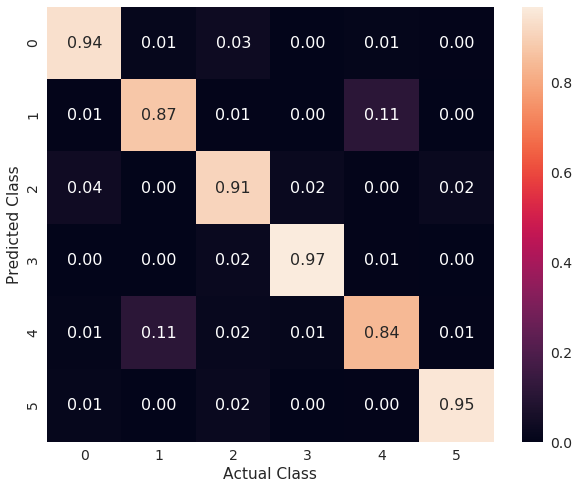

In [15]:
plt.figure(figsize = (10,8))
sn.set(font_scale=1.4)
sn.heatmap(CM, annot=True, annot_kws={"size": 16}, fmt='.2f')
plt.ylabel('Predicted Class')
plt.xlabel('Actual Class')

plt.show()

### The confusion matrix reveals that: 
1. Classes 0, 3 and 5 have the best performance.
2. Class 4 shows the worst performance.
3. Classes 1 and 4 are most frequently mislabeled as each-other.



# 3.4 Possible Future Steps

### To get better performance one might try:

1. Using data augmentation worked very well at fixing the generalization gap. Trying different transformations such as a horizontal flip or horizontal stretch might be an interesting way to train the data.
2. Spend some time investigating classes 1 and 4 and try to get some insight as to why they are so commonly misclassified. This behavior was also observed when using transfer learning.
3. Log-normalization of the dataset was useful. Research other audio processing techniques that might better represent the data for training.